In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_PATH = 'data/'
JOB_POSTINGS_PATH = DATA_PATH + 'gsearch_jobs.csv'
COMPANIES_PATH = DATA_PATH + 'companies.csv'
INDUSTRIES_PATH = DATA_PATH + 'industries.csv'
COMPANY_INDUSTRY_PATH = DATA_PATH + 'company_industries.csv'
EMPLOYEE_COUNTS_PATH = DATA_PATH + 'employee_counts.csv'
JOB_LEVEL_VERIFY_PATH = DATA_PATH + 'verify_job_level_extraction.csv'
PROCESSED_DATA_PATH = DATA_PATH + 'dataframe_after_preprocessing.csv'
TFIDF_PATH = DATA_PATH + 'tfidf_mtx.csv'
BERT_PATH = DATA_PATH + 'bert_embeddings.csv'
W2V_PATH = DATA_PATH + 'w2v.csv'

In [3]:
df_merged = pd.read_csv(PROCESSED_DATA_PATH)

In [4]:
df_merged.columns

Index(['description', 'work_from_home', 'salary', 'salary_pay', 'salary_rate',
       'salary_avg', 'salary_min', 'salary_max', 'salary_hourly',
       'salary_yearly', 'salary_standardized', 'description_tokens',
       'company_size', 'Years_of_Experience', 'level_Entry', 'level_Mid',
       'level_Senior', 'level_Unspecified', 'city_Broken Arrow, OK',
       'city_Columbia, MO', 'city_Edmond, OK', 'city_Fayetteville, AR',
       'city_Fort Smith, AR', 'city_Independence, MO', 'city_Kansas City, KS',
       'city_Kansas City, MO', 'city_Lawrence, KS', 'city_Lawton, OK',
       'city_Lee's Summit, MO', 'city_Norman, OK', 'city_Oklahoma City, OK',
       'city_Olathe, KS', 'city_Overland Park, KS', 'city_Rogers, AR',
       'city_Springdale, AR', 'city_Springfield, MO', 'city_Topeka, KS',
       'city_Tulsa, OK', 'city_Wichita, KS', 'city_minor_cities',
       'city_Broken Arrow, OK.1', 'city_Columbia, MO.1', 'city_Edmond, OK.1',
       'city_Fayetteville, AR.1', 'city_Fort Smith, AR.1

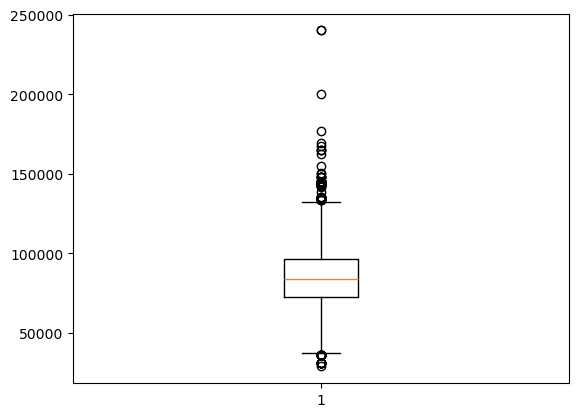

In [5]:
plt.boxplot(df_merged['salary_standardized'])
plt.show()

In [6]:
df_merged.loc[df_merged['salary_standardized'].idxmin()]

description                            Senior Principal Analyst - Data Management Tec...
work_from_home                                                                       NaN
salary                                                               12.19–15.56 an hour
salary_pay                                                                   12.19–15.56
salary_rate                                                                      an hour
                                                             ...                        
industry_Technology                                                                False
industry_Telecommunications                                                         True
industry_Transportation & Logistics                                                False
num_skills                                                                             0
required_soft_skills                   ['planning', 'sales', 'leadership', 'managemen...
Name: 486, Length: 85

### Baseline Linear Regression

In [7]:
for item in eval(df_merged['required_soft_skills'][0]):
    print(item)

operations
sales
quality assurance
teamwork
reliability
management
analytical skills
adaptability


In [8]:
from collections import Counter
all_skills = []
for i in range(len(df_merged)):
    for skill in eval(df_merged['required_soft_skills'][i]):
        all_skills.append(skill)
skill_counts = Counter(all_skills)
skill_counts_df = pd.DataFrame(skill_counts.items(), columns=['Skill', 'Count'])
skill_counts_df = skill_counts_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
print(skill_counts_df.head(20))


                     Skill  Count
0               management   5140
1                 research   2900
2               leadership   2860
3               operations   2208
4                 planning   2192
5               innovation   1613
6            collaboration   1488
7   information technology   1289
8               governance   1270
9            presentations   1264
10                   sales   1221
11             integration   1218
12                 writing   1052
13   written communication    958
14         decision making    899
15        microsoft office    871
16              consulting    871
17       analytical skills    862
18         problem solving    807
19          communications    804


In [9]:
import statsmodels.api as sm 
x2 = sm.add_constant(df_merged['Years_of_Experience'].fillna(0))
model = sm.OLS(df_merged['salary_standardized'], x2).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     salary_standardized   R-squared:                       0.003
Model:                             OLS   Adj. R-squared:                  0.003
Method:                  Least Squares   F-statistic:                     22.47
Date:                 Fri, 13 Dec 2024   Prob (F-statistic):           2.17e-06
Time:                         15:33:48   Log-Likelihood:                -89056.
No. Observations:                 7846   AIC:                         1.781e+05
Df Residuals:                     7844   BIC:                         1.781e+05
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                8.3

### Template to train and evaluate models

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def train_and_evaluate_models(X, y):
    models = [
        LogisticRegression(),
        SVC(),
        GradientBoostingClassifier(),
        RandomForestClassifier(),
        KNeighborsClassifier(),
        GaussianNB(),
        MLPClassifier()
    ]
    model_names = [
        'Logistic Regression', 
        'SVM', 
        'Gradient Boosting', 
        'Random Forest', 
        'KNN', 
        'Naive Bayes', 
        'Neural Network'
    ]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    for model, model_name in zip(models, model_names):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(model_name)
        print('Accuracy: ', accuracy_score(y_test, y_pred))
        print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
        print('Classification Report: \n', classification_report(y_test, y_pred))
        print('\n')

### Classification Model

Accuracy:  0.9165605095541401
Confusion Matrix: 
 [[725  31]
 [100 714]]
Classification Report: 
               precision    recall  f1-score   support

        high       0.88      0.96      0.92       756
         low       0.96      0.88      0.92       814

    accuracy                           0.92      1570
   macro avg       0.92      0.92      0.92      1570
weighted avg       0.92      0.92      0.92      1570



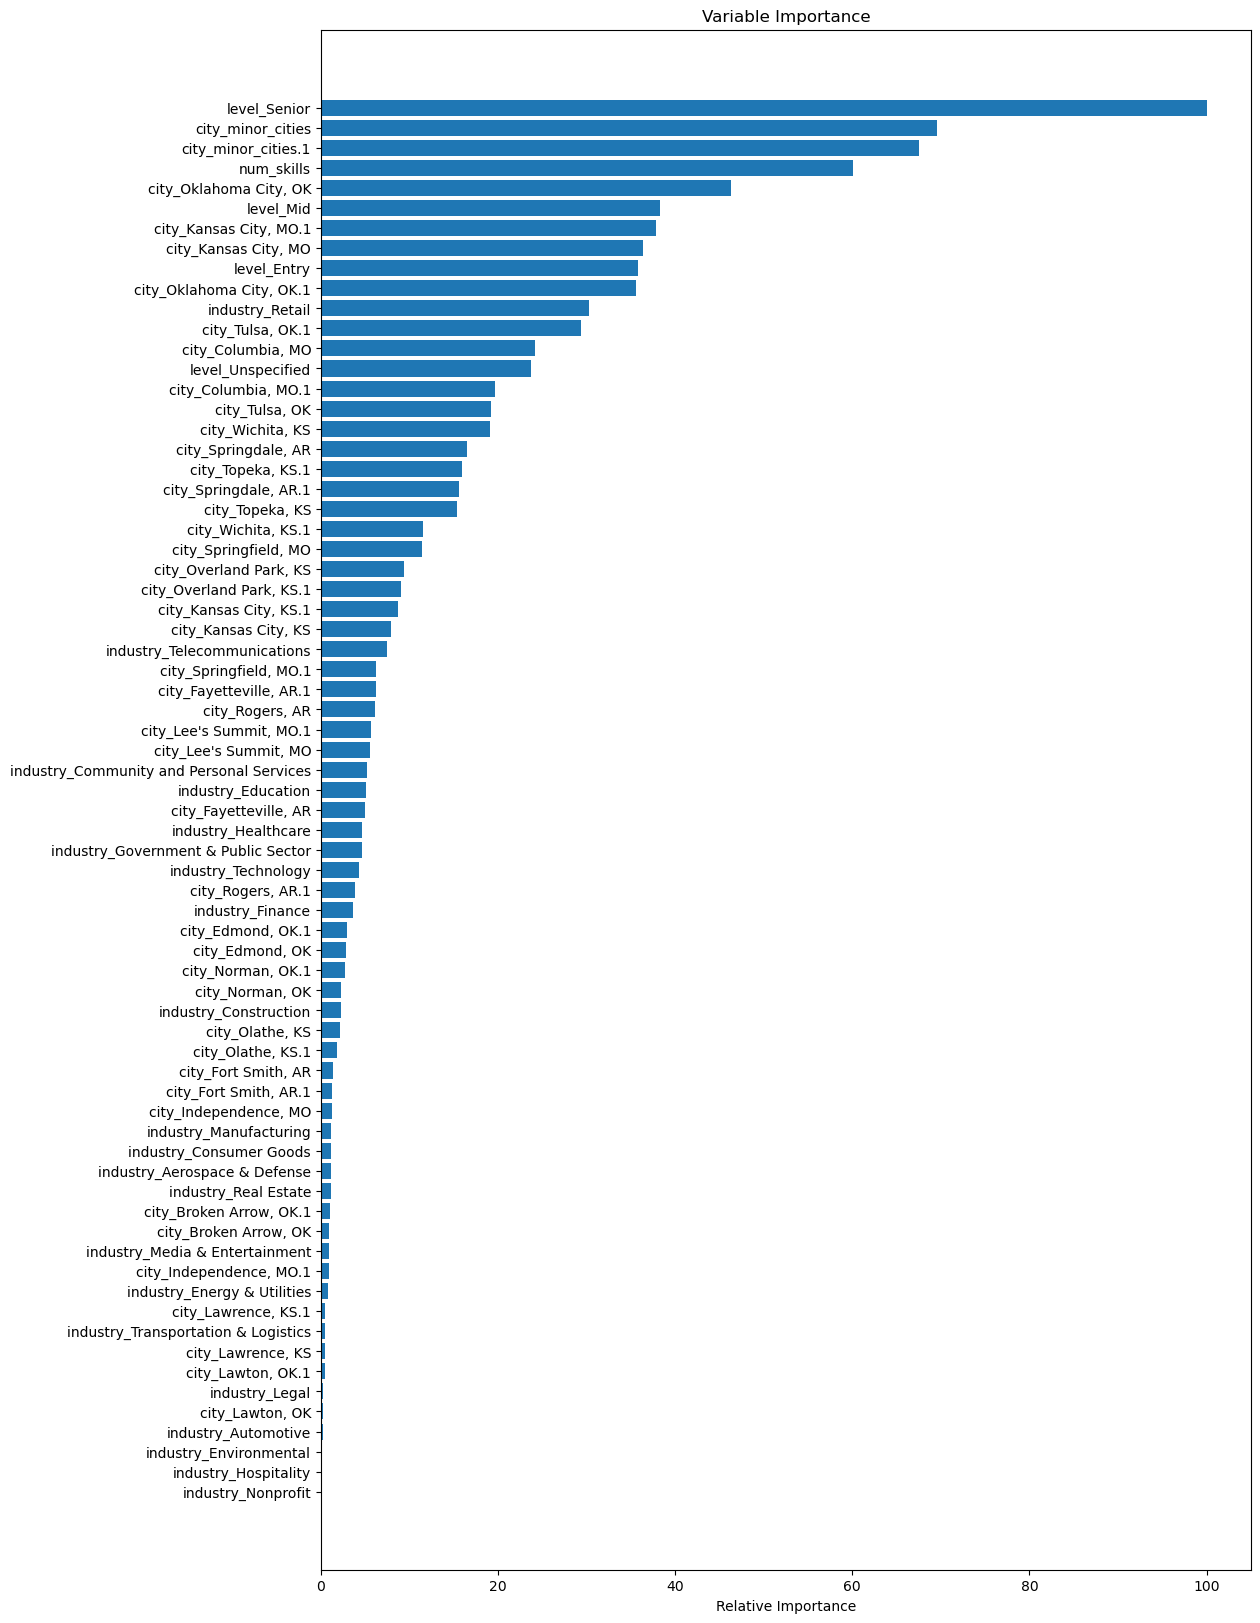

In [11]:
# Categorize salary into high and low according to the median
df_merged['salary_category'] = np.where(df_merged['salary_standardized'] > df_merged['salary_standardized'].median(), 'high', 'low')

# fit the model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = df_merged[['level_Entry', 'level_Mid',
       'level_Senior', 'level_Unspecified', 'city_Broken Arrow, OK',
       'city_Columbia, MO', 'city_Edmond, OK', 'city_Fayetteville, AR',
       'city_Fort Smith, AR', 'city_Independence, MO', 'city_Kansas City, KS',
       'city_Kansas City, MO', 'city_Lawrence, KS', 'city_Lawton, OK',
       "city_Lee's Summit, MO", 'city_Norman, OK', 'city_Oklahoma City, OK',
       'city_Olathe, KS', 'city_Overland Park, KS', 'city_Rogers, AR',
       'city_Springdale, AR', 'city_Springfield, MO', 'city_Topeka, KS',
       'city_Tulsa, OK', 'city_Wichita, KS', 'city_minor_cities',
       'city_Broken Arrow, OK.1', 'city_Columbia, MO.1', 'city_Edmond, OK.1',
       'city_Fayetteville, AR.1', 'city_Fort Smith, AR.1',
       'city_Independence, MO.1', 'city_Kansas City, KS.1',
       'city_Kansas City, MO.1', 'city_Lawrence, KS.1', 'city_Lawton, OK.1',
       "city_Lee's Summit, MO.1", 'city_Norman, OK.1',
       'city_Oklahoma City, OK.1', 'city_Olathe, KS.1',
       'city_Overland Park, KS.1', 'city_Rogers, AR.1',
       'city_Springdale, AR.1', 'city_Springfield, MO.1', 'city_Topeka, KS.1',
       'city_Tulsa, OK.1', 'city_Wichita, KS.1', 'city_minor_cities.1',
       'industry_Aerospace & Defense', 'industry_Automotive',
       'industry_Community and Personal Services', 'industry_Construction',
       'industry_Consumer Goods', 'industry_Education',
       'industry_Energy & Utilities', 'industry_Environmental',
       'industry_Finance', 'industry_Government & Public Sector',
       'industry_Healthcare', 'industry_Hospitality', 'industry_Legal',
       'industry_Manufacturing', 'industry_Media & Entertainment',
       'industry_Nonprofit', 'industry_Real Estate', 'industry_Retail',
       'industry_Technology', 'industry_Telecommunications',
       'industry_Transportation & Logistics', 'num_skills']].fillna(0)
y = df_merged['salary_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification Report: \n', classification_report(y_test, y_pred))

# Feature importance
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 20))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [12]:
# Try multiple models
train_and_evaluate_models(X, y)

Logistic Regression
Accuracy:  0.8834394904458599
Confusion Matrix: 
 [[704  52]
 [131 683]]
Classification Report: 
               precision    recall  f1-score   support

        high       0.84      0.93      0.88       756
         low       0.93      0.84      0.88       814

    accuracy                           0.88      1570
   macro avg       0.89      0.89      0.88      1570
weighted avg       0.89      0.88      0.88      1570



SVM
Accuracy:  0.8885350318471338
Confusion Matrix: 
 [[687  69]
 [106 708]]
Classification Report: 
               precision    recall  f1-score   support

        high       0.87      0.91      0.89       756
         low       0.91      0.87      0.89       814

    accuracy                           0.89      1570
   macro avg       0.89      0.89      0.89      1570
weighted avg       0.89      0.89      0.89      1570



Gradient Boosting
Accuracy:  0.9089171974522293
Confusion Matrix: 
 [[720  36]
 [107 707]]
Classification Report: 
       

Best Model: Random Forest Classifier & Neural Network

### BERT embeddings

In [13]:
# build a BERT model for job descriptions
from transformers import BertTokenizer, BertModel
import torch
    
if not os.path.exists(BERT_PATH):
    # Load the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    if torch.cuda.is_available():
        print ('cuda')
    else:
        print('cpu')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Tokenize the job descriptions
    batch_size = 16
    embeddings = []
    
    for i in range(0, len(df_merged), batch_size):
        batch_texts = df_merged['description'].tolist()[i:i+batch_size]
        encoded_inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')
        input_ids = encoded_inputs['input_ids'].to(device)
        attention_mask = encoded_inputs['attention_mask'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.append(batch_embeddings)
    
    embeddings = np.vstack(embeddings)
    bert_embeddings_df = pd.DataFrame(embeddings, index=df_merged.index)
    bert_embeddings_df.to_csv(BERT_PATH, index=False)
else:
    bert_embeddings_df = pd.read_csv(BERT_PATH)

In [14]:
import statsmodels.api as sm 
X_combined_bert = pd.concat([X, bert_embeddings_df], axis=1)

X_train_bert, X_test_bert, y_train, y_test = train_test_split(X_combined_bert, y, test_size=0.25, random_state=699)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_bert, y_train)

y_pred = clf.predict(X_test_bert)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification Report: \n', classification_report(y_test, y_pred))

Accuracy:  0.845565749235474
Confusion Matrix: 
 [[809 156]
 [147 850]]
Classification Report: 
               precision    recall  f1-score   support

        high       0.85      0.84      0.84       965
         low       0.84      0.85      0.85       997

    accuracy                           0.85      1962
   macro avg       0.85      0.85      0.85      1962
weighted avg       0.85      0.85      0.85      1962



### Word2Vec embeddings

In [15]:
import ast

df_merged['required_soft_skills'] = df_merged['required_soft_skills'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_merged['description_tokens'] = df_merged['description_tokens'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

corpus = df_merged['required_soft_skills'].tolist() + df_merged['description_tokens'].tolist()
corpus[:5]

[['operations',
  'sales',
  'quality assurance',
  'teamwork',
  'reliability',
  'management',
  'analytical skills',
  'adaptability'],
 [],
 ['sales',
  'governance',
  'leadership',
  'sorting',
  'strategic thinking',
  'management',
  'research',
  'innovation',
  'integration',
  'curiosity',
  'filing',
  'collaboration',
  'presentations',
  'supervision',
  'resilience',
  'information technology',
  'positivity',
  'editing'],
 ['planning', 'management', 'decision making', 'writing', 'business acumen'],
 ['planning', 'leadership', 'management']]

In [16]:
# Generate Word2Vec embeddings for job descriptions
if True: #not os.path.exists(W2V_PATH):
    from gensim.models import Word2Vec

    vector_size = 100
    
    w2v_model1 = Word2Vec(sentences=corpus, vector_size=vector_size, window=5, min_count=1, workers=4)
    w2v_model1.train(df_merged['description'], total_examples=w2v_model1.corpus_count, epochs=10)

    wv = w2v_model1.wv
    #After filtering for min frequency, there are 5514 words in the corpus
    words = list(wv.key_to_index)
    print('Vocabulary size:%d' % len(words))

    def get_w2v_embeddings(tokens, model, vector_size=vector_size):
        embeddings = np.zeros(vector_size)
        count = 0
        for token in tokens:
            if token in model.wv:
                embeddings += model.wv[token]
                count += 1
        if count > 0:
            embeddings /= count
        return embeddings
    
    w2v_embeddings = df_merged['description'].apply(lambda x: get_w2v_embeddings(x, w2v_model1))
    
    # Convert the embeddings to a DataFrame
    w2v_embeddings_df = pd.DataFrame(w2v_embeddings.tolist(), index=df_merged.index)
    
    w2v_embeddings_df.to_csv(W2V_PATH, index=False)
else:
    w2v_embeddings_df = pd.read_csv(W2V_PATH)

Vocabulary size:307


In [17]:
# Combine the original features with the Word2Vec embeddings
X_combined_w2v = pd.concat([X, w2v_embeddings_df], axis=1)
X_combined_w2v.columns = X_combined_w2v.columns.astype(str)

train_and_evaluate_models(X_combined_w2v, y)
# Added hard skills into corpus (rather than soft skills only), RF and KNN decreased ~0.01, naive bayes dropped from 0.80 to 0.69
# Other models improved ~0.01

Logistic Regression
Accuracy:  0.8834394904458599
Confusion Matrix: 
 [[704  52]
 [131 683]]
Classification Report: 
               precision    recall  f1-score   support

        high       0.84      0.93      0.88       756
         low       0.93      0.84      0.88       814

    accuracy                           0.88      1570
   macro avg       0.89      0.89      0.88      1570
weighted avg       0.89      0.88      0.88      1570



SVM
Accuracy:  0.8878980891719745
Confusion Matrix: 
 [[686  70]
 [106 708]]
Classification Report: 
               precision    recall  f1-score   support

        high       0.87      0.91      0.89       756
         low       0.91      0.87      0.89       814

    accuracy                           0.89      1570
   macro avg       0.89      0.89      0.89      1570
weighted avg       0.89      0.89      0.89      1570



Gradient Boosting
Accuracy:  0.8961783439490446
Confusion Matrix: 
 [[700  56]
 [107 707]]
Classification Report: 
       

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x154bff4e9e40>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split

Random Forest
Accuracy:  0.8980891719745223
Confusion Matrix: 
 [[681  75]
 [ 85 729]]
Classification Report: 
               precision    recall  f1-score   support

        high       0.89      0.90      0.89       756
         low       0.91      0.90      0.90       814

    accuracy                           0.90      1570
   macro avg       0.90      0.90      0.90      1570
weighted avg       0.90      0.90      0.90      1570



KNN
Accuracy:  0.9057324840764331
Confusion Matrix: 
 [[708  48]
 [100 714]]
Classification Report: 
               precision    recall  f1-score   support

        high       0.88      0.94      0.91       756
         low       0.94      0.88      0.91       814

    accuracy                           0.91      1570
   macro avg       0.91      0.91      0.91      1570
weighted avg       0.91      0.91      0.91      1570



Naive Bayes
Accuracy:  0.697452229299363
Confusion Matrix: 
 [[710  46]
 [429 385]]
Classification Report: 
               preci

In [18]:
# Random Forest Regressor, support vector machine, and gradient boosting regressor using pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error

X_train_w2v, X_test_w2v, y_reg_train, y_reg_test = train_test_split(X_combined_w2v, df_merged['salary_standardized'], test_size=0.25, random_state=699)

# Ensure all column names are strings
X_train_w2v.columns = X_train_w2v.columns.astype(str)
X_test_w2v.columns = X_test_w2v.columns.astype(str)

# Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=699)
rf_pipeline = Pipeline([('scaler', StandardScaler()), ('rf', rf_regressor)])
rf_pipeline.fit(X_train_w2v, y_reg_train)
rf_mse = mean_squared_error(y_reg_test, rf_pipeline.predict(X_test_w2v))
print("Random Forest MSE:", rf_mse)

Random Forest MSE: 240044105.4529944


In [19]:
# Support Vector Machine Regressor
svr_regressor = SVR()
svr_pipeline = Pipeline([('scaler', StandardScaler()), ('svr', svr_regressor)])
svr_pipeline.fit(X_train_w2v, y_reg_train)
svr_mse = mean_squared_error(y_reg_test, svr_pipeline.predict(X_test_w2v))
print("SVM MSE:", svr_mse)

SVM MSE: 416085951.200504


In [20]:
# Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=699)
gb_pipeline = Pipeline([('scaler', StandardScaler()), ('gb', gb_regressor)])
gb_pipeline.fit(X_train_w2v, y_reg_train)
gb_mse = mean_squared_error(y_reg_test, gb_pipeline.predict(X_test_w2v))
print("Gradient Boosting MSE:", gb_mse)

Gradient Boosting MSE: 226411771.48386556


Regression task still got pretty poor performance

### Pretrained GloVe Model Embeddings

In [21]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

In [22]:
# !unzip glove.6B.zip

In [24]:
# GloVe Model
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

if not os.path.exists('glove.6B.100d.word2vec.txt'):
    # Convert GloVe to Word2Vec format
    glove2word2vec('glove.6B.100d.txt', 'glove.6B.100d.word2vec.txt')


# Load the Word2Vec model
glove_model = KeyedVectors.load_word2vec_format(W2V_PATH, binary=False)

def get_glove_w2v_embeddings(tokens, model, vector_size=100):
    embeddings = np.zeros(vector_size)
    count = 0
    for token in tokens:
        if token in model:
            embeddings += model[token]
            count += 1
    if count > 0:
        embeddings /= count
    return embeddings

# Generate GloVe embeddings for job descriptions
glove_embeddings = df_merged['description'].apply(lambda x: get_glove_w2v_embeddings(x, glove_model))

# Convert the embeddings to a DataFrame
glove_embeddings_df = pd.DataFrame(glove_embeddings.tolist(), index=df_merged.index)

ValueError: invalid literal for int() with base 10: '0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69

In [ ]:
# Combine the original features with the Word2Vec embeddings
X_combined_glove = pd.concat([X, glove_embeddings_df], axis=1)
X_combined_glove.columns = X_combined_glove.columns.astype(str)

train_and_evaluate_models(X_combined_glove, y)

### TFIDF Feature

In [ ]:
tfidf_mtx = pd.read_csv(TFIDF_PATH)

In [ ]:
X_combined_tfidf = pd.concat([X, tfidf_mtx], axis=1)
X_combined_tfidf.columns = X_combined_tfidf.columns.astype(str)

train_and_evaluate_models(X_combined_tfidf, y)

### Try including both W2V and TFIDF

In [ ]:
X_combined_w2v_tfidf = pd.concat([X, w2v_embeddings_df, tfidf_mtx], axis=1)
X_combined_w2v_tfidf.columns = X_combined_w2v_tfidf.columns.astype(str)

train_and_evaluate_models(X_combined_w2v_tfidf, y)

### Multi-Classification

In [ ]:
df_merged['salary_multiclass'] = pd.qcut(df_merged['salary_standardized'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

In [ ]:
# Combine the original features with the Word2Vec embeddings
X_combined_w2v = pd.concat([X, w2v_embeddings_df], axis=1)
X_combined_w2v.columns = X_combined_w2v.columns.astype(str)

y_multi = df_merged['salary_multiclass']

train_and_evaluate_models(X_combined_w2v, y_multi)

In [ ]:
# # Try multiple models
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.neural_network import MLPClassifier

# models = [LogisticRegression(), SVC(), GradientBoostingClassifier(), KNeighborsClassifier(), GaussianNB(), MLPClassifier()]
# model_names = ['Logistic Regression', 'SVM', 'Gradient Boosting', 'KNN', 'Naive Bayes', 'Neural Network']
# accuracy_list = []

# for model, model_name in zip(models, model_names):
#     model.fit(X_train_w2v, y_train)
#     y_pred = model.predict(X_test_w2v)
#     print(model_name)
#     print('Accuracy: ', accuracy_score(y_test, y_pred))
#     print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
#     print('Classification Report: \n', classification_report(y_test, y_pred))
#     print('\n')

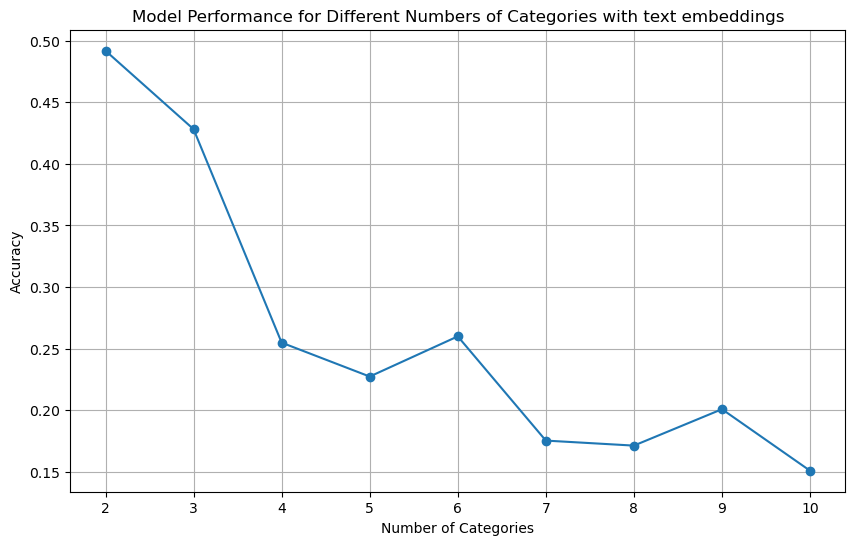

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

def train_and_evaluate_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=699)
    
    model = MLPClassifier(random_state=699)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

performance = []

for num_categories in range(2, 11):
    df_merged['salary_multiclass'] = pd.qcut(df_merged['salary_standardized'], 
                                             q=num_categories, 
                                             labels=[f'Category {i+1}' for i in range(num_categories)])
    
    y_multi = df_merged['salary_multiclass']
    
    # X_combined_w2v = pd.concat([X, w2v_embeddings_df], axis=1)
    X_combined_w2v = pd.concat([w2v_embeddings_df], axis=1)
    X_combined_w2v.columns = X_combined_w2v.columns.astype(str)
    
    accuracy = train_and_evaluate_models(X_combined_w2v, y_multi)
    
    performance.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), performance, marker='o')
plt.title('Model Performance for Different Numbers of Categories with text embeddings')
plt.xlabel('Number of Categories')
plt.ylabel('Accuracy')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()